In [1]:
%matplotlib inline

In [2]:
import os
# For windows
os.environ['PROJ_LIB'] = 'C:\Anaconda\Library\share'

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import LinearNDInterpolator
from pyproj import transform, Proj

# Linux
# plt.rcParams['animation.ffmpeg_path'] = '~/miniconda2/envs/particles/bin/ffmpeg'

# Windows
#plt.rcParams['animation.ffmpeg_path'] = 'C:\\Anaconda\\envs\\py37\\'

plt.rcParams['animation.bitrate'] = 2000

In [3]:
# зададим константы
NUM_PARTICLES = 100
NUM_ITER = 24
STEP = 3600  # sec
SEED = 42

Uw, Vw = 50, 50 # см/с
W = np.array([Uw, Vw])

In [4]:
# системы координат
wgs84 = Proj(init="EPSG:4326")
local_crs = Proj(init="EPSG:2463")

In [5]:
# получаем данные из файла
data = np.genfromtxt('6.csv', delimiter=';', skip_header=True)
data[data==-999] = np.nan
lonlat, current_velocity = data[:, 1::-1], data[:, 2:]

x, y = transform(wgs84, local_crs, lonlat[:, 0], lonlat[:, 1])
xy = np.vstack([x, y]).T

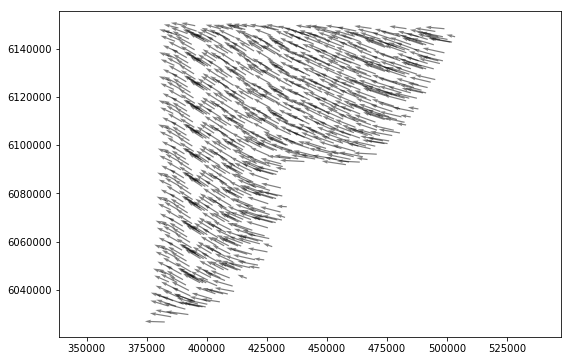

In [6]:
# посмотрим на данные
fig, ax = plt.subplots(figsize=(9,6))
ax.quiver(xy[::10, 0], xy[::10, 1], current_velocity[::10, 0], current_velocity[::10, 1], scale=200, scale_units='width', alpha=0.5)
ax.axis('equal')
pass

In [7]:
# создадим функцию интерполяции данных
get_current_velocity = LinearNDInterpolator(xy, current_velocity)

def get_velocity(xy, speed_param):
    C = get_current_velocity(xy)
    velocity = (C + speed_param * W) / (1 + speed_param)
    velocity *= 0.01  # переведем из см/с в м/с
    return velocity

In [8]:
# типы точек
point_types = pd.read_excel('Particles 1.xlsx')
point_types.columns = ['type', 'number', 'speed_param']
# присвоим каждому типу свой цвет
point_types['color'] = ['red', 'green', 'blue', 'orange']
point_types.set_index('type', inplace=True)
point_types

,number,speed_param,color
type,,,
1,50,0.010356,red
2,50,0.005979,green
3,50,0.116554,blue
4,50,0.013370,orange


In [9]:
# получим гранницы данных
bounds = np.hstack([xy.min(axis=0), xy.max(axis=0)])
bounds_lonlat = np.hstack([lonlat.min(axis=0), lonlat.max(axis=0)])

In [10]:
# рассчитаем состояние системы на каждой итерации для каждой частицы
# state - 3-мерный массив [NUM_ITER х NUM_PARTICLES х 4]
# по последней оси размерностью 4 храним X, Y, Vx, Vy

def init_state(bounds, num_particles, speed_param, seed=None):
    """Инициализация состояния системы"""
    x_min, y_min, x_max, y_max = bounds
    rs = np.random.RandomState(seed)
    x = rs.normal((x_min + x_max) / 2, (x_min + x_max) / 200, num_particles)
    y = rs.normal((y_min + y_max) / 2, (y_min + y_max) / 500, num_particles)
    xy = np.vstack([x, y]).T
    velocity = get_velocity(xy, speed_param)
    return np.hstack([xy, velocity])

def get_state(state_prev, step, speed_param):
    """Получает текущее состояние по предыдущему"""
    xy_prev = state_prev[:, :2]
    velocity_prev = state_prev[:, 2:]
    xy_cur = xy_prev + step*velocity_prev
    velocity_cur = get_velocity(xy_cur, speed_param)
    states_cur = np.hstack([xy_cur, velocity_cur])
    return states_cur

p_type_states = {}
for p_type, row in point_types.iterrows():
    num_points = row.number
    speed_param = row.speed_param
    states = np.ones([NUM_ITER, num_points, 4], dtype=float) * np.nan
    states[0, :, :] = init_state(bounds, num_points, speed_param, seed=None)
    for n in range(1, NUM_ITER):
        states[n, :, :] = get_state(states[n-1, :, :], STEP, speed_param)        
    p_type_states[p_type] = states
p_type_states

{1: array([[[ 4.34840302e+05,  6.09694359e+06, -7.96030916e-02,
           3.15060443e-02],
         [ 4.34963735e+05,  6.06542334e+06, -3.64996509e-02,
           1.02041575e-02],
         [ 4.46333799e+05,  6.06106601e+06,             nan,
                      nan],
         ...,
         [ 4.39817822e+05,  6.09816041e+06, -8.12265780e-02,
           3.17539299e-02],
         [ 4.41480192e+05,  6.09084860e+06, -4.92029152e-02,
           1.00302263e-02],
         [ 4.42855196e+05,  6.09479152e+06, -8.80850257e-02,
           2.44063977e-02]],
 
        [[ 4.34553731e+05,  6.09705701e+06, -7.90262156e-02,
           3.19521075e-02],
         [ 4.34832336e+05,  6.06546008e+06, -3.66079277e-02,
           1.01861867e-02],
         [            nan,             nan,             nan,
                      nan],
         ...,
         [ 4.39525406e+05,  6.09827473e+06, -8.09033625e-02,
           3.19501068e-02],
         [ 4.41303061e+05,  6.09088470e+06, -5.12691687e-02,
           1.00

(376397.34570309933, 509336.7930950199, 6005195.760985305, 6160225.979850985)

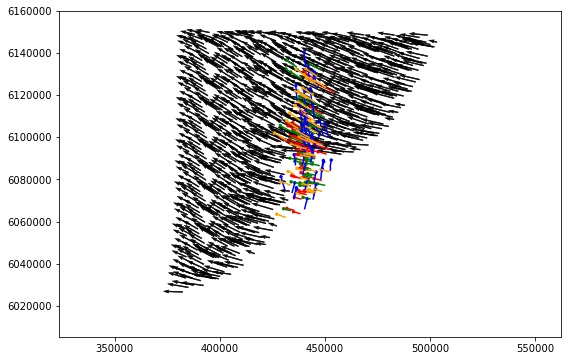

In [11]:
# посмотрим на получившиеся треки
fig, ax = plt.subplots(figsize=(9,6))
for p_type, states in p_type_states.items():
    color = point_types.loc[p_type, 'color']
    ax.quiver(xy[::10, 0], xy[::10, 1], current_velocity[::10, 0], current_velocity[::10, 1], scale=200, scale_units='width', alpha=0.5)
    ax.plot(states[:, :, 0], states[:, :, 1], color=color)
    ax.quiver(states[-1, :, 0], states[-1, :, 1], states[-1, :, 2], states[-1, :, 3], color=color, scale=20)

# ax.set_xlim(bounds[0::2])
# ax.set_ylim(bounds[1::2])
ax.axis('equal')

In [12]:
# сейчас координаты в states мы рассчитали в метрах
# переведем их в wgs84, чтобы отобразить на карте

for states in p_type_states.values():
    for i in range(states.shape[0]):
        states[i, :, 0], states[i, :, 1] = transform(local_crs, wgs84, states[i, :, 0], states[i, :, 1])

RuntimeError: Error creating movie, return code: 1

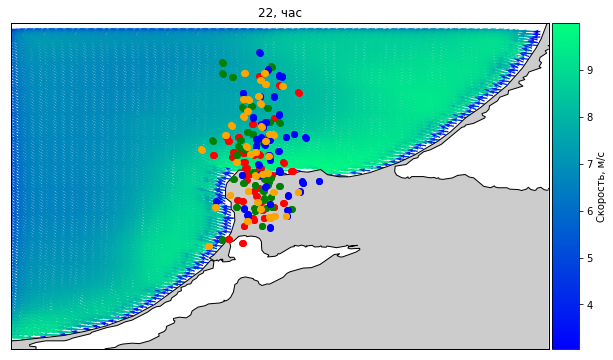

In [19]:
# рисуем анимацию

# создаем рисунок
fig, ax = plt.subplots(figsize=(12,6))

# добавляем континенты
m = Basemap(
    llcrnrlon=bounds_lonlat[0]-0.03,
    llcrnrlat=bounds_lonlat[1]-0.03,
    urcrnrlon=bounds_lonlat[2]+0.03,
    urcrnrlat=bounds_lonlat[3]+0.03,
    epsg="4326",
    resolution='h',
)
m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()

# добавляем поле скоростей
q = ax.quiver(
    lonlat[:, 0],
    lonlat[:, 1],
    current_velocity[:, 0],
    current_velocity[:, 1],
    np.linalg.norm(current_velocity, axis=1),
    scale=200,
    scale_units='width',
    cmap='winter',
)

# добавляем colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(q, cax=cax, label='Скорость, м/с')
lines = []
for p_type, states in p_type_states.items():
    color = point_types.loc[p_type, 'color']
    for i in range(states.shape[1]):
        lines.append(ax.plot([], [], color=color, linestyle='', marker='o')[0])

# инициализация линий для анимации
def init():
    for line in lines:
        line.set_data([], [])
    return lines

# обновлении линий на каждой итерации
def update(frame):
    ax.set_title('{}, час'.format(frame*STEP//3600))
    line_idx = 0
    for p_type, states in p_type_states.items():
        for i in range(states.shape[1]):
            x = states[frame:frame+2, i, 0]
            y = states[frame:frame+2, i, 1]
            lines[line_idx].set_data(x, y)
            line_idx += 1
    return lines

# cоздаем и сохраняем анимацию
ani = animation.FuncAnimation(
    fig,
    update,
    frames=NUM_ITER-1,
    init_func=init,
    interval=1000,
    blit=True,
)
ani.save('animation.mp4',  writer=animation.FFMpegFileWriter())